# Analyse de la qualité des signatures manuscrites en-ligne pour améliorer la vérification d’identité

Ce projet est un projet de cours portant sur l'apprentissage non-supervisé dans le cadre du cursus ingénieur de Télécom SudParis. </br>
**Pour des raisons de confidentialité et de protection des données, les données utilisées dans ce projet ne sont pas fournies et leur tracé n'est pas affiché.**

Cette étude de cas concerne l’analyse d’une base de données de signatures manuscrites dites « en-ligne », acquises sur un dispositif numérique (tablette graphique). Ainsi, on peut étudier la dynamique du geste produit lors de la signature. La base de données utilisée est MCYT-100. Elle contient 100 sujets ayant chacun réalisé 25 signatures de référence. Ajoutées à ces signatures, nous est fourni la complexité des 2500 signatures (25 signatures authentiques des 100 personnes) qui a été calculée avec le modèle GMM couplé à la mesure d’entropie différentielle, et cela pour différents nombres de gaussiennes : $n \in {4,8,16}$

À terme, cette analyse permettra de faire de la classification de signature avec un traitement non-supervisé afin de détecter si une nouvelle signature appartient bien à son propriétaire ou si c’est une fraude.

## I - Analyse de la qualité des signatures manuscrites

### I.1 - Imporation des données
Chaque signature de chaque personne représente une série temporelle de 5 attributs :
- La position $(X,Y)$ de la bille du stylet sur l’écran
- La pression $P$
- L’angle d’inclinaison Azimutal $Az$
- Et l’altitude $Al$ du stylet


In [4]:
#useful imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [5]:
# for files in directory, read them and store them in a list
def read_files(directory, only_zeros=False):
    files = []
    for file in os.listdir(directory):
        if file.endswith(".txt"):
            tmp = pd.read_csv(directory + file, sep=" ",header=None)
            tmp.columns = ["X","Y", "P", "Az", "Al"]
            if not only_zeros:
                tmp = tmp[tmp["P"] != 0]
            else:
                tmp = tmp[tmp["P"] == 0]
            tmp["participant"] = int(file.split("v")[0])
            tmp["signature"] = int(file.split("v")[1].split(".")[0])
            files.append(tmp)
    return files

# make a df with all the files with a column specifying the file
def make_df(files):
    df = pd.DataFrame()
    for file in files:
        df = pd.concat([df, file])
    return df

In [6]:
data = make_df(read_files("./Données/Base de données/"))
data.sort_values(by=["participant", "signature"], inplace=True)
data_zeros = make_df(read_files("./Données/Base de données/", only_zeros=True))

In [7]:
data.describe()

,X,Y,P,Az,Al,participant,signature
count,686522.000000,686522.000000,686522.000000,686522.000000,686522.000000,686522.000000,686522.000000
mean,5526.742418,4671.092715,608.501390,149.906841,59.103468,52.288131,12.021246
std,2891.020117,2467.687009,244.092905,36.618502,6.409491,28.774222,7.208630
min,0.000000,0.000000,1.000000,23.000000,29.000000,0.000000,0.000000
25%,2800.000000,2693.000000,443.000000,130.000000,55.000000,29.000000,6.000000
50%,5688.000000,4666.000000,622.000000,144.000000,59.000000,52.000000,12.000000
75%,7242.000000,6665.750000,788.000000,160.000000,63.000000,77.000000,18.000000
max,12699.000000,9642.000000,1023.000000,365.000000,87.000000,99.000000,24.000000


### I.2 Visualisation des données avec graphique
En traçant en pointillés les coordonnées $(X,Y)$ où la pression est nulle, on obtient le tracé de la signature. On peut ainsi visualiser les signatures pour chaque personne.

In [8]:
# plot a random sample of 100 signatures on a subplot grid
def plot_sample(df, df_zeros, participants=[i for i in range(100)]):
    fig, ax = plt.subplots(10,10, figsize=(20,20))
    for i in range(10):
        for j in range(10):
            participant = participants[i*10+j]
            signature = np.random.randint(0,24)
            tmp = df[(df["participant"] == participant) & (df["signature"] == signature)]
            tmp_zeros = df_zeros[(df_zeros["participant"] == participant) & (df_zeros["signature"] == signature)]
            ax[i,j].plot(tmp["X"], tmp["Y"])
            ax[i,j].plot(tmp_zeros["X"], tmp_zeros["Y"], linestyle="--")
            ax[i,j].axis("off")
            ax[i,j].set_title(str(participant) + "v" + str(signature))
    plt.show()

# plot_sample(data, data_zeros)

# II Travail expérimental

On peut déjà remarquer plusieurs types de signatures : les signatures très simples, ne constituent que quelques traits et sont amples et d’autres sont plus complexes et ont le centre saturé de traits. On cherche donc à déterminer un critère de complexité pour chaque signature, afin de pouvoir les classer.

## II.1 Mesure de la complexité par individu

In [9]:
def plot_25(df, df_zeros, participant):
    fig, ax = plt.subplots(5,5, figsize=(20,20))
    for i in range(5):
        for j in range(5):
            signature = 5*i + j
            tmp = df[(df["participant"] == participant) & (df["signature"] == signature)]
            tmp_zeros = df_zeros[(df_zeros["participant"] == participant) & (df_zeros["signature"] == signature)]
            ax[i,j].plot(tmp["X"], tmp["Y"])
            ax[i,j].plot(tmp_zeros["X"], tmp_zeros["Y"], linestyle="--")
            ax[i,j].axis("off")
            ax[i,j].set_title(str(participant) + "v" + str(signature))
    plt.show()

In [10]:
# En ayant édité les fichiers de complexité pour qu'ils soient lisibles (remplacement de "," par "."):
complexity24G = pd.read_csv("./Données/Complexités/Complexité avec 24G (100x25).txt", sep="\t", header=None)
complexity8G = pd.read_csv("./Données/Complexités/Complexité avec 8G (100x25).txt", sep="\t", header=None)
complexity4G = pd.read_csv("./Données/Complexités/Complexité avec 4G (100x25).txt", sep="\t", header=None)

complexity24G_means = pd.DataFrame(complexity24G.T.describe().mean())
complexity8G_means = pd.DataFrame(complexity8G.T.describe().mean())
complexity4G_means = pd.DataFrame(complexity4G.T.describe().mean())

complexity24G_means.columns = ["mean"]
complexity8G_means.columns = ["mean"]
complexity4G_means.columns = ["mean"]

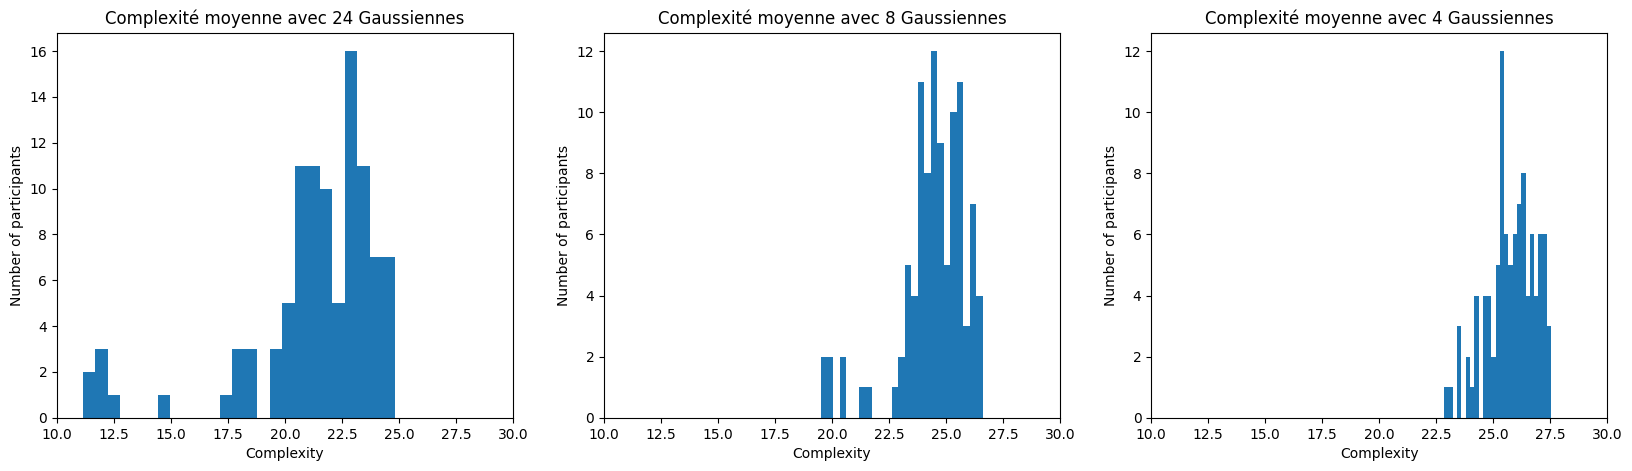

In [11]:
# plot histogram chart with number of participant having the same complexity
subplots = [complexity24G_means, complexity8G_means, complexity4G_means]
titles = ["Complexité moyenne avec 24 Gaussiennes", "Complexité moyenne avec 8 Gaussiennes", "Complexité moyenne avec 4 Gaussiennes"]
fig, ax = plt.subplots(1,3, figsize=(20,5))
for i in range(3):
    ax[i].hist(subplots[i], bins=25)
    ax[i].set_title(titles[i])
    ax[i].set_xlabel("Complexity")
    ax[i].set_ylabel("Number of participants")
    ax[i].set_xlim(10,30)

plt.show()

En ayant représenté la répartition de la complexité moyenne de chacune des signatures, on remarque qu'avec un nombre de gaussienne élevé, on parvient à déterminer trois groupes de signatures. On utilise donc des algorithmes de clustering pour déterminer ces groupes.

## II - Groupage des 100 individu en 3 catégories

### II.1 - Utilisation de K-Means et Gaussian Mixture

On utilise deux algorithmes de clustering : K-Means et Gaussian Mixture. Le nombre de clusters est fixé à 3. On utilise la complexité moyenne des signatures pour déterminer les clusters. Ainsi, chaque individu est classé dans un cluster.

In [12]:
from sklearn.cluster import KMeans

# clusterize the complexity means with kmeans

kmeans = KMeans(n_clusters=3, random_state=0)
for complexity_mean,n in zip([complexity24G_means, complexity8G_means, complexity4G_means],[24,8,4]):
    kmeans.fit(complexity_mean["mean"].values.reshape(-1,1))
    complexity_mean["cluster kmeans"] = kmeans.labels_
    globals()[f"centroids_kmeans_{n}"] = kmeans.cluster_centers_

/home/sauvt/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/sauvt/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/sauvt/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [13]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=3)
for complexity_means,n in zip([complexity24G_means, complexity8G_means, complexity4G_means, complexity4G_means],[24,8,4]):
    gmm.fit(complexity_means["mean"].values.reshape(-1,1))
    complexity_means["cluster gmm"] = gmm.predict(complexity_means["mean"].values.reshape(-1,1))
    globals()[f"centroids_gmm_{n}"] = gmm.means_

In [14]:
#plot signature of each participants in the same cluster (up to 25)
def plot_cluster(df, df_zeros, means, cluster, cluster_type):
    fig = plt.figure(figsize=(20,20))
    participants = means[means[cluster_type] == cluster].index
    for i in range(10):
        for j in range(10):
            if i*10+j >= len(participants):
                break
            participant = participants[i*10+j]
            ax = fig.add_subplot(7,7,i*10+j+1)
            signature = np.random.randint(0,25)
            tmp = df[(df["participant"] == participant) & (df["signature"] == signature)]
            tmp_zeros = df_zeros[(df_zeros["participant"] == participant) & (df_zeros["signature"] == signature)]
            ax.plot(tmp["X"], tmp["Y"])
            ax.plot(tmp_zeros["X"], tmp_zeros["Y"], linestyle="--")
            ax.axis("off")
            ax.set_title(str(participant) + "v" + str(signature))
    plt.suptitle("Cluster comportant " + str(means[cluster_type].value_counts()[cluster]) + "% des données (" + cluster_type + ")")
    
    plt.show()

In [15]:
# plot_cluster(data, data_zeros, complexity24G_means, 0, "cluster kmeans")
# plot_cluster(data, data_zeros, complexity24G_means, 1, "cluster kmeans")
# plot_cluster(data, data_zeros, complexity24G_means, 2, "cluster kmeans")

In [16]:
# plot_cluster(data, data_zeros, complexity24G_means, 0, "cluster gmm")
# plot_cluster(data, data_zeros, complexity24G_means, 1, "cluster gmm")
# plot_cluster(data, data_zeros, complexity24G_means, 2, "cluster gmm")

On obtient les répartitions suivantes :

Avec K-Means : 

| | Signatures complexes | Signatures simples | Autres signatures |
| -------- | -------- | -------- | -------- |
| 4 Gaussiennes | 43 | 16 | 41 |
| 8 Gaussiennes | 42 | 8 | 50 |
| 24 Gaussiennes | 47 | 7 | 46 |


Avec Gaussian Mixture :

| | Signatures complexes | Signatures simples | Autres signatures |
| -------- | -------- | -------- | -------- |
| 4 Gaussiennes | 36 | 18 | 46 |
| 8 Gaussiennes | 40 | 8 | 52 |
| 24 Gaussiennes | 47 | 7 | 46 |

On remarque que :

- Pour 4G : K-Means était plus proche du résultat trouvé à 24G que GMM
- Pour 8 et 24 Gaussiennes : K-Means et GMM obtiennent approximativement la même répartition de signature dans les 3 classes.


Pour mieux visualiser la classification, on fait une appréciaiton visuelle des complexités des signatures des personnes en chaque cluster.

In [17]:
# make 4 subplots, in the first two, plot the scattered dots with the centroids and the histogram with the colors, in the second two, plot the same but with the GMM
colors = ["red", "blue", "green"]

#define if you want to plot de scatterplot and boxplot of what cluster

def plot_scatter_boxplot(complexity_means, centroids_kmeans, centroids_gmm, nG):
    fig, ax = plt.subplots(2,2, figsize=(20,5), gridspec_kw={'width_ratios': [1, 1], 'height_ratios': [2, 1]})
    for n, y in enumerate(centroids_kmeans):
        ax[1,0].plot(y, 0, marker='x', color=colors[n], ms=10)
    ax[1,0].scatter(complexity_means["mean"], [i for i in range(100)] , c=complexity_means["cluster kmeans"], cmap = "viridis")
    ax[0,0].hist([complexity_means["mean"][complexity_means["cluster kmeans"] == i] for i in range(3)], bins=25, color=colors)

    ax[0,0].set_xlabel("Complexité")
    ax[0,0].set_ylabel("Nombre de participants")

    for n, y in enumerate(centroids_gmm):
        ax[1,1].plot(y, 0, marker='x', color=colors[n], ms=10)
    ax[1,1].scatter(complexity_means["mean"], [i for i in range(100)],  c=complexity_means["cluster gmm"], cmap = "viridis")
    ax[0,1].hist([complexity_means["mean"][complexity_means["cluster gmm"] == i] for i in range(3)], bins=25, color=colors)

    ax[0,1].set_xlabel("Complexité")
    ax[0,1].set_ylabel("Nombre de participants")

    ax[1,0].axis("off")
    ax[1,1].axis("off")
    ax[0,0].set_title(f"Complexité moyenne avec {nG} Gaussiennes (Kmeans)")
    ax[0,1].set_title(f"Complexité moyenne avec {nG} Gaussiennes (GMM)")

    plt.show()

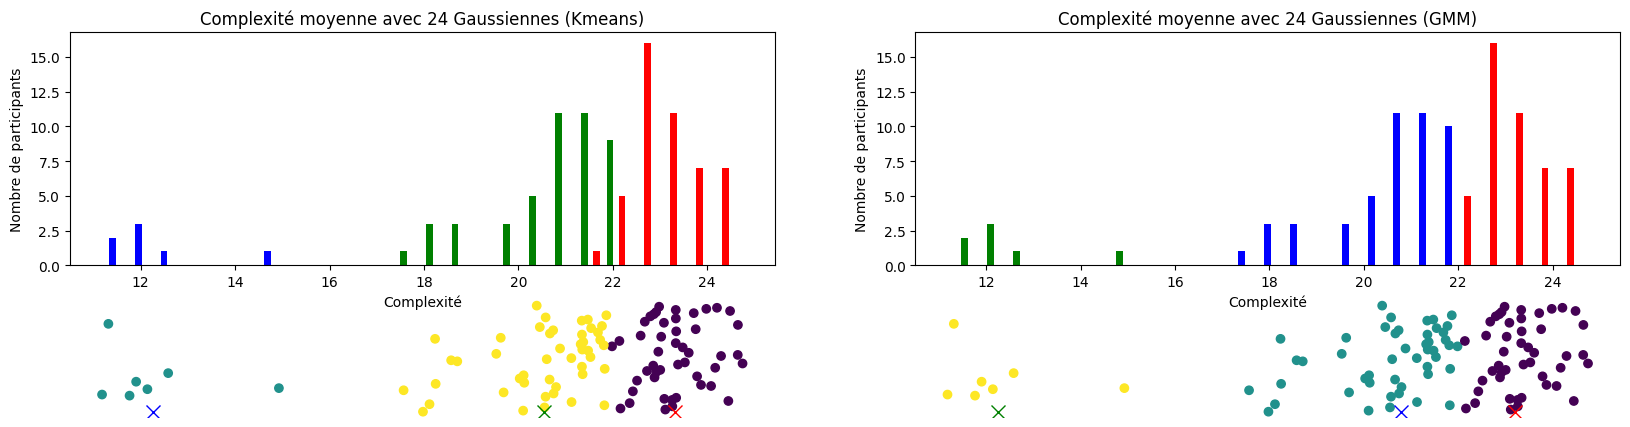

In [18]:
plot_scatter_boxplot(complexity24G_means, centroids_kmeans_24, centroids_gmm_24, 24)

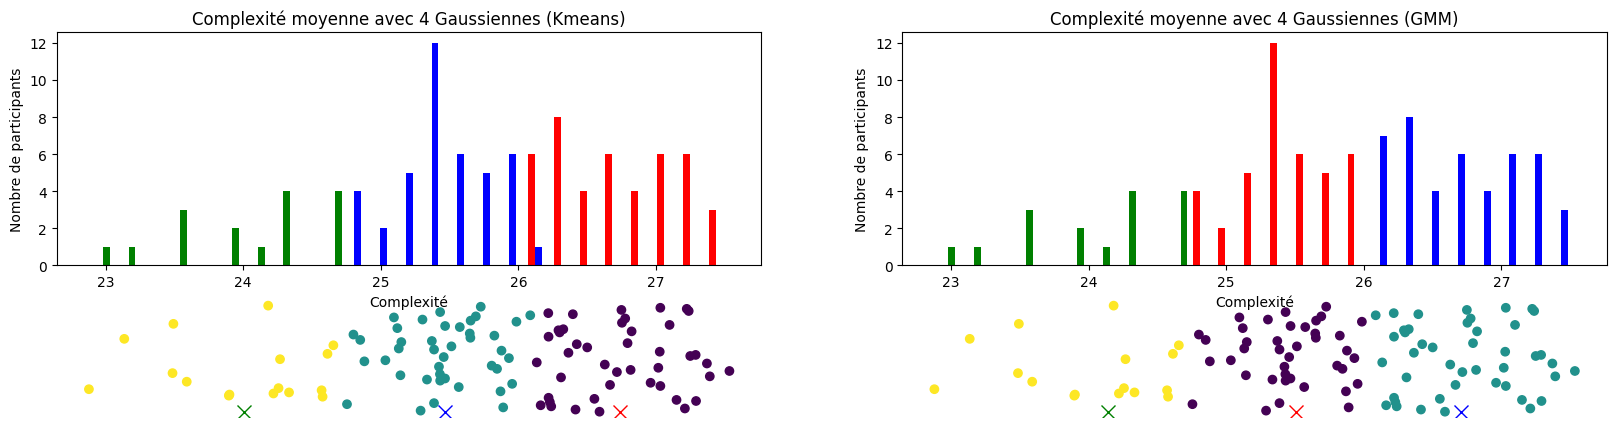

In [19]:
plot_scatter_boxplot(complexity4G_means, centroids_kmeans_4, centroids_gmm_4, 4)

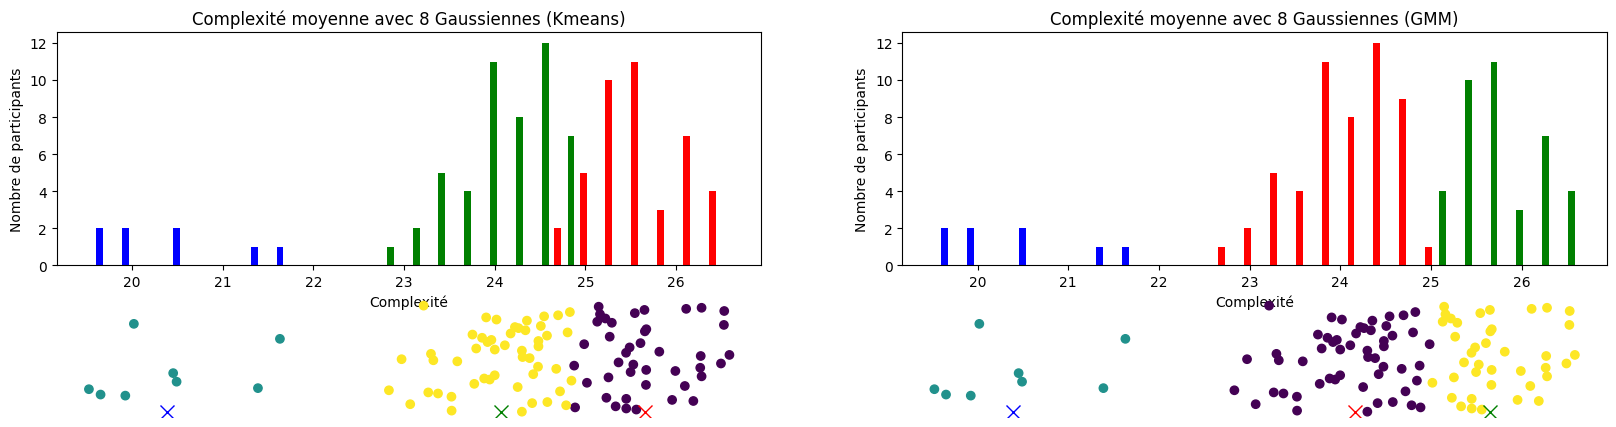

In [20]:
plot_scatter_boxplot(complexity8G_means, centroids_kmeans_8, centroids_gmm_8, 8)

### II.3 Comparaisons en fonction du nombre de Gaussiennes

In [21]:
# Inertie intra et inter clusters

def compute_intra_inertia(means, cluster_type):
    inertia = 0
    for i in range(3):
        cluster = means[means[cluster_type] == i]
        for j in range(len(cluster)):
            inertia += (cluster.iloc[j]["mean"] - cluster["mean"].mean())**2
    return inertia


# Inertie inter clusters

def compute_inter_inertia(means, cluster_type):
    inertia = 0
    for i in range(3):
        cluster = means[means[cluster_type] == i]
        inertia += (cluster["mean"].mean() - means["mean"].mean())**2 * len(cluster)
    return inertia

for complexity_means,n in zip([complexity4G_means, complexity8G_means, complexity24G_means],[4,8,24]):
    intra_kmean=str(compute_intra_inertia(complexity_means, "cluster gmm"))
    intra_gmm=str(compute_intra_inertia(complexity_means, "cluster kmeans"))
   
    print(f"Intra-clusters Kmeans pour {n}G (à minimiser): {intra_kmean}")
    print(f"Intra-clusters GMM pour {n}G (à minimiser):  {intra_gmm}")

    print("Inter-clusters Kmeans pour"+str(n)+"G (à maximiser): " + str(compute_inter_inertia(complexity_means, "cluster kmeans")))
    print("Inter-clusters GMM pour"+str(n)+"4G (à maximiser): " + str(compute_inter_inertia(complexity_means, "cluster gmm")))


Intra-clusters Kmeans pour 4G (à minimiser): 16.67180932935341
Intra-clusters GMM pour 4G (à minimiser):  16.647101385008774
Inter-clusters Kmeans pour4G (à maximiser): 95.42129735024324
Inter-clusters GMM pour44G (à maximiser): 95.39658940589882
Intra-clusters Kmeans pour 8G (à minimiser): 28.151861787802307
Intra-clusters GMM pour 8G (à minimiser):  27.89438067389477
Inter-clusters Kmeans pour8G (à maximiser): 203.41283765587184
Inter-clusters GMM pour84G (à maximiser): 203.1553565419637
Intra-clusters Kmeans pour 24G (à minimiser): 96.82909001315144
Intra-clusters GMM pour 24G (à minimiser):  96.59133814670788
Inter-clusters Kmeans pour24G (à maximiser): 804.4080429766148
Inter-clusters GMM pour244G (à maximiser): 804.1702911101712


Pour une complexité calculée avec 24 gaussiennes, on obtient les répartitions suivantes :

| |  Distance inter-clusters | Distance intra-clusters |
| -------- | -------- | -------- |
| GMM | 804.17 | 96.59 |
| K-Means | 804.40 | 96.83 |

Pour une complexité calculée avec 8 gaussiennes, on obtient les répartitions suivantes :
| |  Distance inter-clusters | Distance intra-clusters |
| -------- | -------- | -------- |
| GMM | 203.41 | 27.89 |
| K-Means | 203.41 | 27.90 |

Pour une complexité calculée avec 4 gaussiennes, on obtient les répartitions suivantes :
| |  Distance inter-clusters | Distance intra-clusters |
| -------- | -------- | -------- |
| GMM | 94.85 | 16.65 |
| K-Means | 95.42 | 17.21 |

On constate que les distances inter cluster (à maximiser) et les distances intra cluster (à minimiser) sont quasi semblables, malgré le fait que GMM performe très légèrement mieux.

On peut par ailleurs conclure que plus le nombre de gaussiennes est grand et plus la précision du modèle de clustering sera grande et fera donc une bonne classification non-supervisée avec un grand écart interclasse (relativement à un faible nombre de gaussiennes) et un faible écart intraclasse.

Les deux méthodes donnent des résultats similaires, on choisit de garder GMM pour la suite.

## III - Classification non-supervisées des signatures (writer-independent)

On cherche à présent à classer chacune des signatures dans les 3 classes déterminées précédemment. On utilise pour cela la complexité avec 24 gaussiennes de chaque signature et GMM pour classifier.

In [22]:
# Apprentissage non-supervisé sur les 2500 complexités
gmm.fit(complexity24G.values.reshape(-1,1))
clusters_gmm = gmm.predict(complexity24G.values.reshape(-1,1))
centroids_gmm = gmm.means_

In [23]:
clusters_gmm=clusters_gmm.reshape(100,25)

np.unique(clusters_gmm[2])

array([0])

On trace des pie charts pour visualiser la répartition des signatures dans les 3 classes selon le participant. On remarque ainsi une part des signatures d'un même participant dans plusieurs classes.

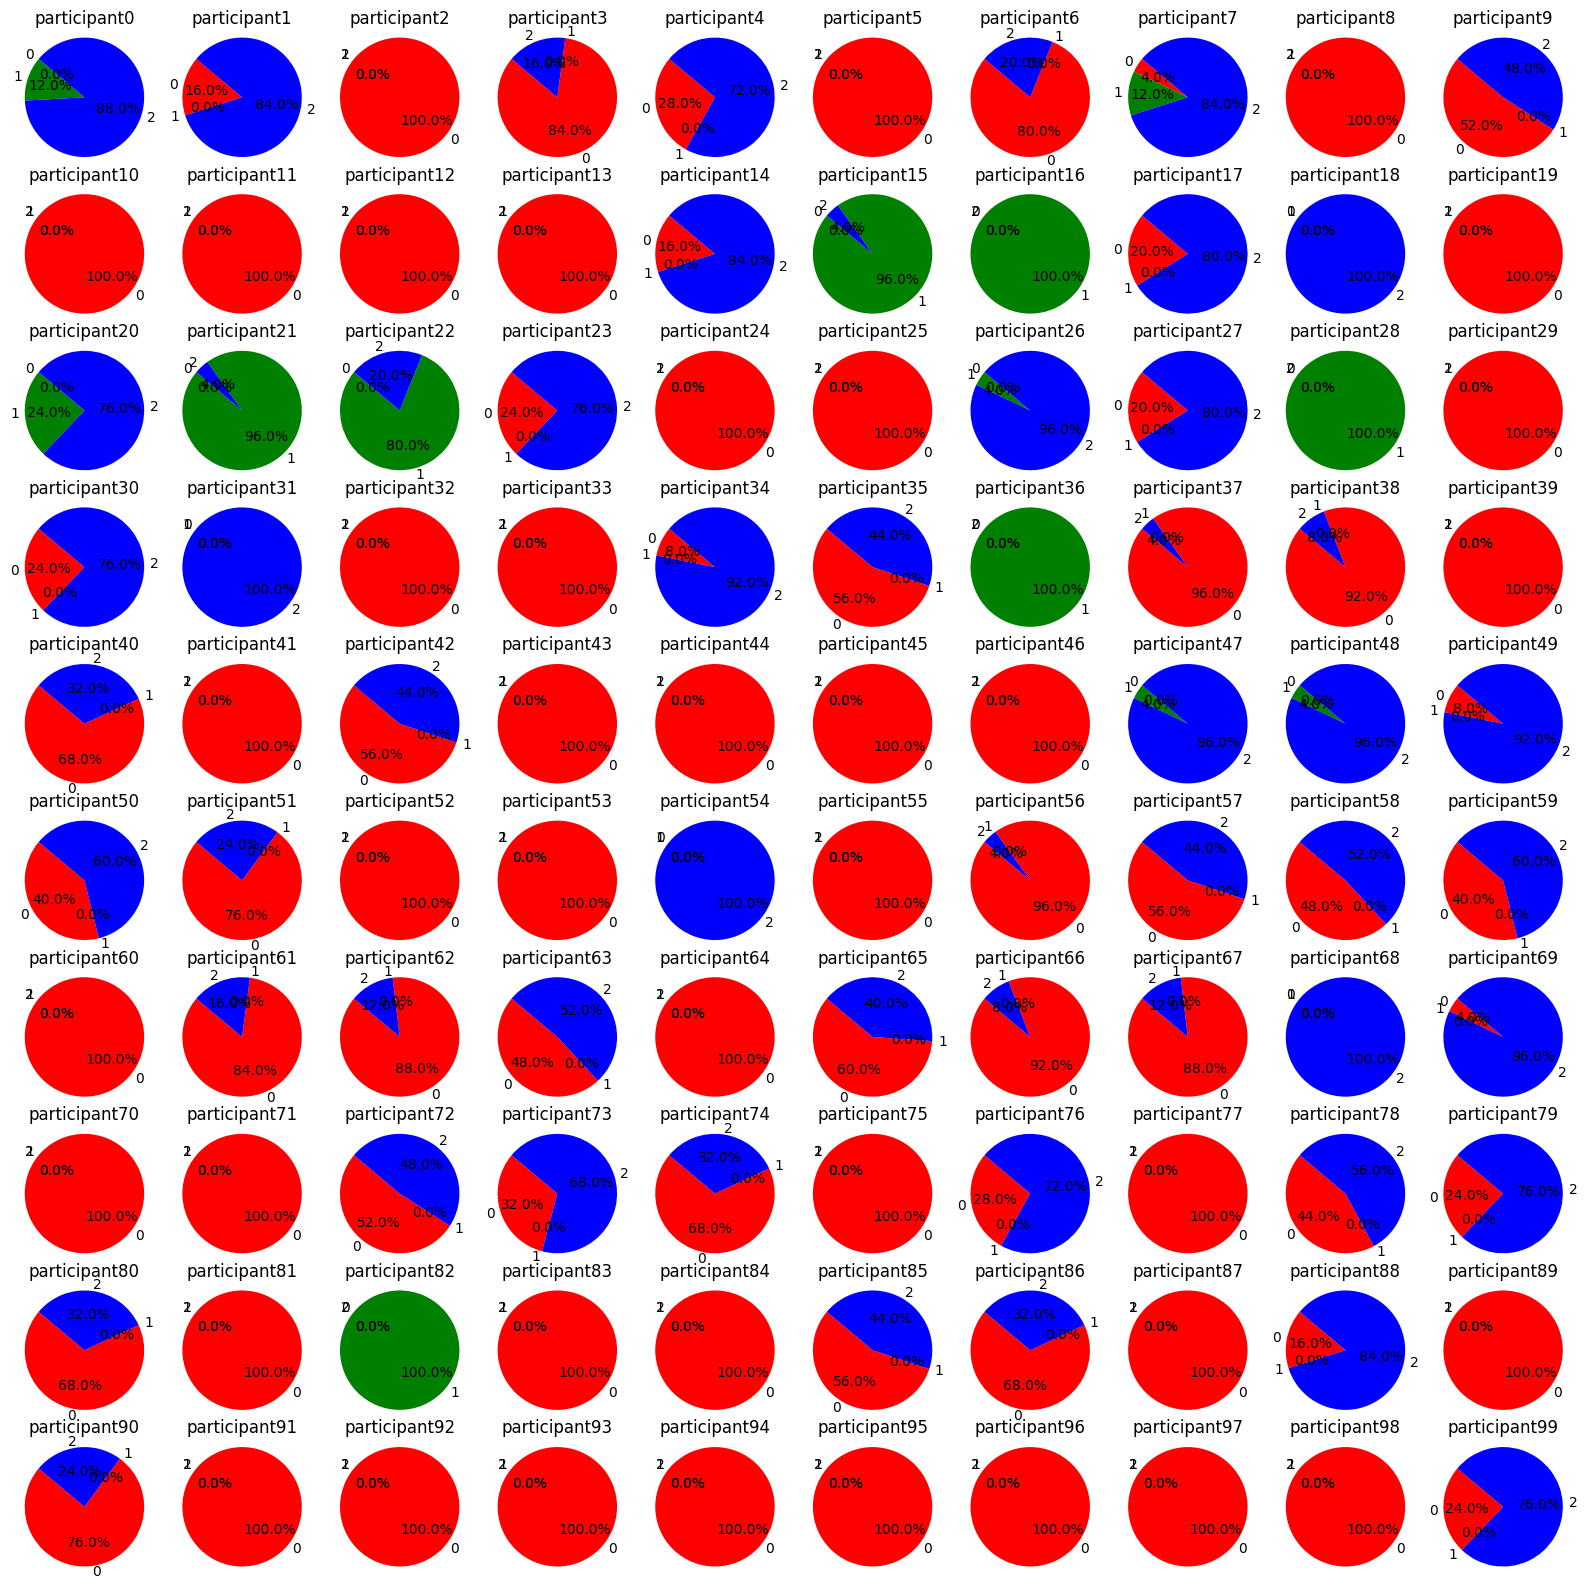

In [24]:
labels = ['0', '1', '2']
colors = ['red', 'green', 'blue']
unclear_participants = []

fig, ax = plt.subplots(10,10, figsize= (20,20))
for i in range(10):
    for j in range(10):
        sizes = np.bincount(clusters_gmm[i*10+j])
        for k in range(3-sizes.shape[0]): # actually, reformat the 0% bit, because not readable
                sizes = np.append(sizes, 0)
        if not((sizes[0] == 25) or (sizes[1] == 25) or (sizes[2] == 25)):
                unclear_participants.append(i*10+j)
        ax[i,j].pie(sizes, labels=labels, colors=colors,
                autopct='%1.1f%%', startangle=140)
        ax[i,j].axis('equal')
        ax[i,j].set_title("participant" + str(i*10+j))

plt.show()  

In [25]:
# plot the signature of each participant in the same cluster.

participants_cluster = [np.bincount(clusters_gmm[i]).argmax() for i in range(100)]

def gmm_plot_clusters(participants, cluster, data = data, data_zeros = data_zeros):
    fig = plt.figure(figsize=(20,20))
    index = 0
    for i in range(len(participants)):
        if participants[i] == cluster:
            ax = fig.add_subplot(10,10,index+1)
            index += 1
            ax.axis("off")
            signature = np.random.randint(0,24)
            tmp = data[(data["participant"] == i) & (data["signature"] == signature)]
            tmp_zeros = data_zeros[(data_zeros["participant"] == i) & (data_zeros["signature"] == signature)]
            ax.plot(tmp["X"], tmp["Y"])
            ax.plot(tmp_zeros["X"], tmp_zeros["Y"], linestyle="--")
            ax.set_title(str(i) + "v" + str(signature))
            plt.suptitle("Cluster " + str(cluster))
    plt.show()

# gmm_plot_clusters(participants_cluster, 0)
# gmm_plot_clusters(participants_cluster, 1)
# gmm_plot_clusters(participants_cluster, 2)

On pourrait qualifier le cluster en rouge (0) comme étant celui des signatures plus complexes, avec beaucoup de traits condensés et le cluster en bleu (2) comme étant celui des signatures plus simples. Les signatures dans le dernier cluster (1) en vert sont souvent confondues entre plusieurs clusters.


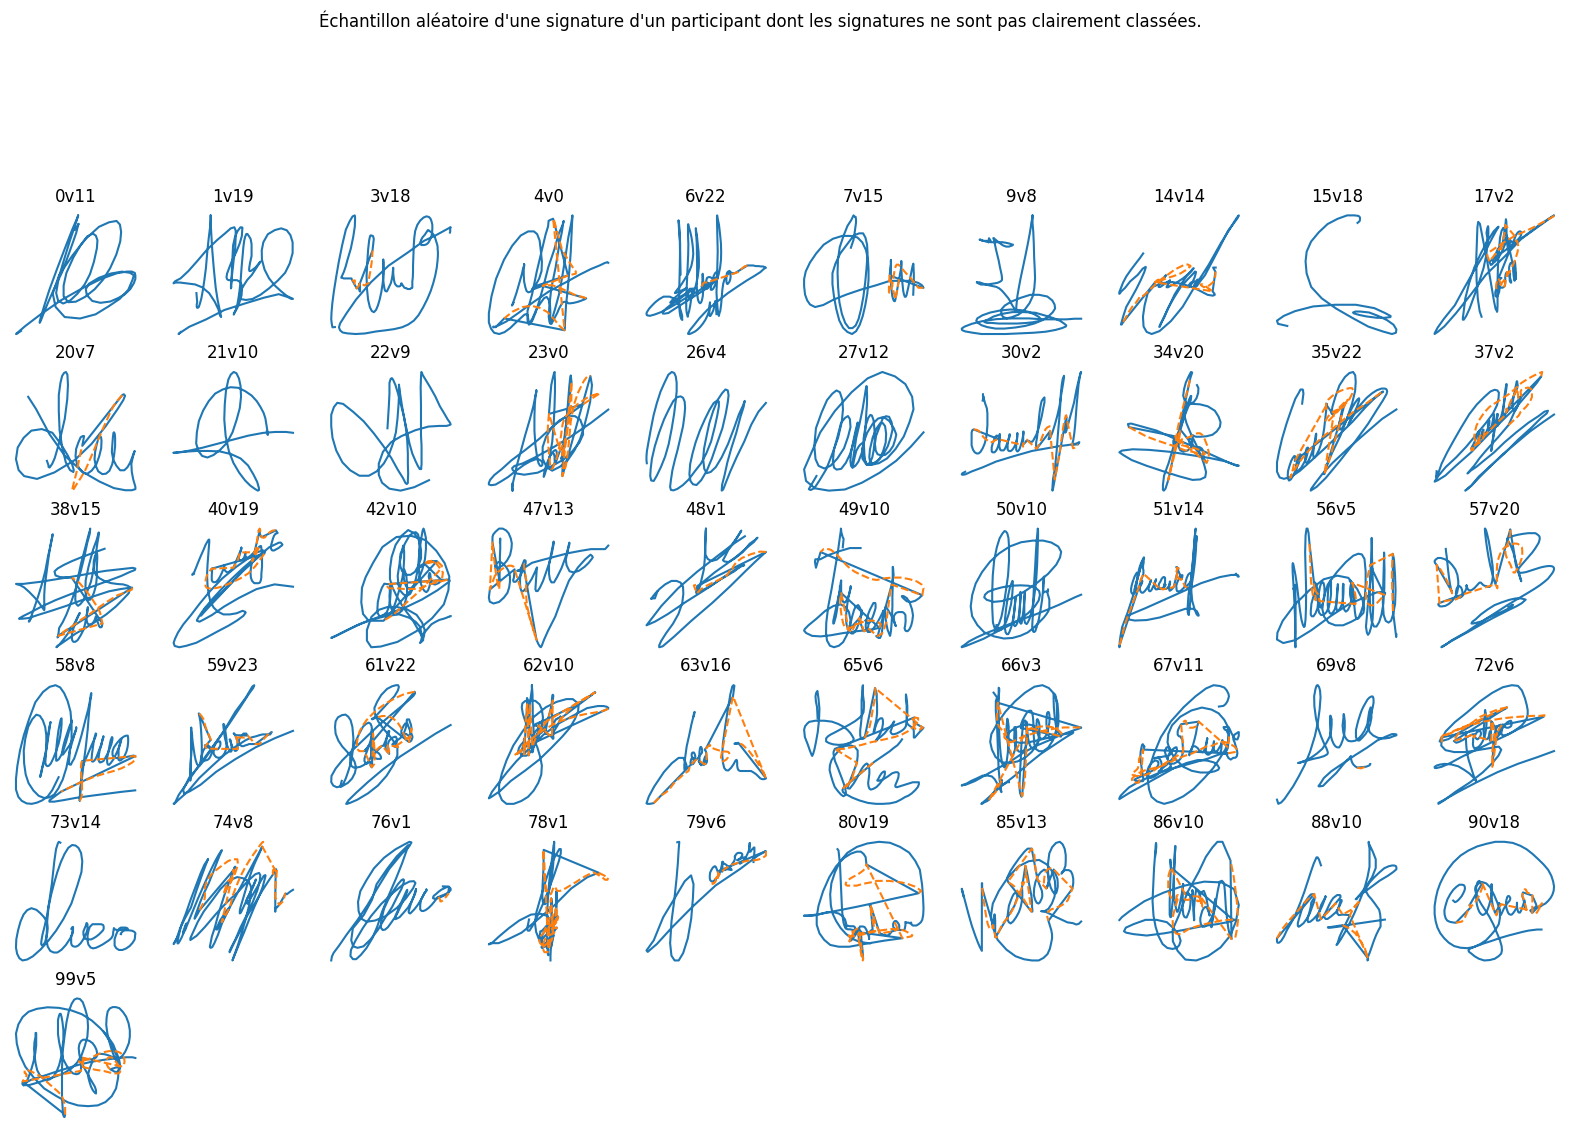

In [26]:
fig = plt.figure(figsize=(20,20))
index = 0
for participant in unclear_participants:
    signature = np.random.randint(0,24)
    tmp = data[(data["participant"] == participant) & (data["signature"] == signature)]
    tmp_zeros = data_zeros[(data_zeros["participant"] == participant) & (data_zeros["signature"] == signature)]
    ax = fig.add_subplot(10,10,index+1)
    ax.plot(tmp["X"], tmp["Y"])
    ax.plot(tmp_zeros["X"], tmp_zeros["Y"], linestyle="--")
    ax.axis("off")
    ax.set_title(str(participant) + "v" + str(signature))
    index += 1


plt.suptitle("Échantillon aléatoire d'une signature d'un participant dont les signatures ne sont pas clairement classées.")

plt.show()

In [27]:
# plot the signatures of participants with several clusters
for participant in unclear_participants:
    clusters = np.unique(clusters_gmm[participant])
    sample = []
    for cluster in clusters:
        sample.append(np.where(clusters_gmm[participant] == cluster)[0][0])

    fig = plt.figure()
    index = 0
    for signature in sample:
        tmp = data[(data["participant"] == participant) & (data["signature"] == signature)]
        tmp_zeros = data_zeros[(data_zeros["participant"] == participant) & (data_zeros["signature"] == signature)]
        ax = fig.add_subplot(1,len(sample),index+1)
        ax.plot(tmp["X"], tmp["Y"])
        ax.plot(tmp_zeros["X"], tmp_zeros["Y"], linestyle="--")
        ax.axis("off")
        ax.axis("equal")
        ax.set_title(str(participant) + "v" + str(signature) + "cluster" + str(index))
        index += 1
    plt.suptitle("Participant " + str(participant) + " : " + str(clusters))
    plt.show()

## IV - Apprentissage et généralisation

On applique maintenant une première classification à la moitié des signatures pour en extraire les représentants de chacun des 3 clusters. Ensuite on applique la méthode des “k plus proches voisins” (KNN) sur l’autre moitié. On a plusieurs choix possibles dans la division des données en deux moitiés : on pourrait choisir purement aléatoirement les signatures parmi les 2500, ou choisir la moitié des participants, ou encore choisir la moitié des signatures pour chacun des participants. On choisira plutôt cette dernière approche, afin d’avoir un échantillon pour chaque participant et de dégager des représentants de chaque cluster qui soient proches de ce que pourraient être ceux des données entières. On prendra ainsi 12 signatures par participant puis 50 signatures aléatoires afin d’avoir 50% de toutes les signatures. 

En effectuant cette classification plusieurs fois pour observer les effets de l’aléatoire sur la classification, on remarque que, pour les participants dont la signature est bien classifiée précédemment, la moitié de leurs signatures est suffisante pour dégager l’appartenance à une classe. Cependant, dans les cas où la limite entre deux clusters est plus floue pour un participant, cela ressort également dans la classification : on note une classification partagée entre deux classes. Même si l’appartenance peut paraître arrêtée sur une classe, il n’est pas certain qu’elle soit totalement déterminée : on pourrait s’approcher d’un cas limite. De même que pour la partie précédente, cela pourrait venir d’une hétérogénéité entre les signatures d’un même participant.


In [28]:
flattened = complexity24G.stack().reset_index()
flattened.columns = ["participant", "signature", "complexity"]

# sample 50% of the data (50% of the signatures of each participant)

first_sample = flattened.groupby("participant").apply(lambda x: x.sample(frac=0.5)).reset_index(drop=True)
first_sample = first_sample.sort_values(by=["participant", "signature"])

while first_sample.shape[0] != 1250:
    first_sample = pd.concat([first_sample, flattened.sample(n=1)], axis=0)
    first_sample.drop_duplicates(subset=["participant", "signature"], inplace=True)

first_sample = first_sample.sort_values(by=["participant", "signature"]).reset_index(drop=True)

# sample_2 is the rest of the data, i.e. flattened - sample_1
second_sample = pd.concat([flattened, first_sample]).drop_duplicates(keep=False)

In [29]:
previous_clusters = clusters_gmm

In [30]:
# # apply GMM on first sample and then k-nearest neighbors on second, based on the centroids of the first
from sklearn.neighbors import KNeighborsClassifier


gmm.fit(first_sample["complexity"].values.reshape(-1,1))
clusters_gmm = gmm.predict(first_sample["complexity"].values.reshape(-1,1))
centroids_gmm = gmm.means_



knn = KNeighborsClassifier()
knn.fit(second_sample["complexity"].values.reshape(-1,1), clusters_gmm)
clusters_knn = knn.predict(second_sample["complexity"].values.reshape(-1,1))

In [31]:
first_sample["cluster"] = clusters_gmm
second_sample["cluster"] = clusters_knn

In [32]:
flattened["cluster"] = previous_clusters.reshape(-1,1)

In [33]:
second_sample["previous_clusters"] = flattened[flattened[["signature", "participant"]].isin(second_sample[["signature", "participant"]]).all(axis=1)]["cluster"].values

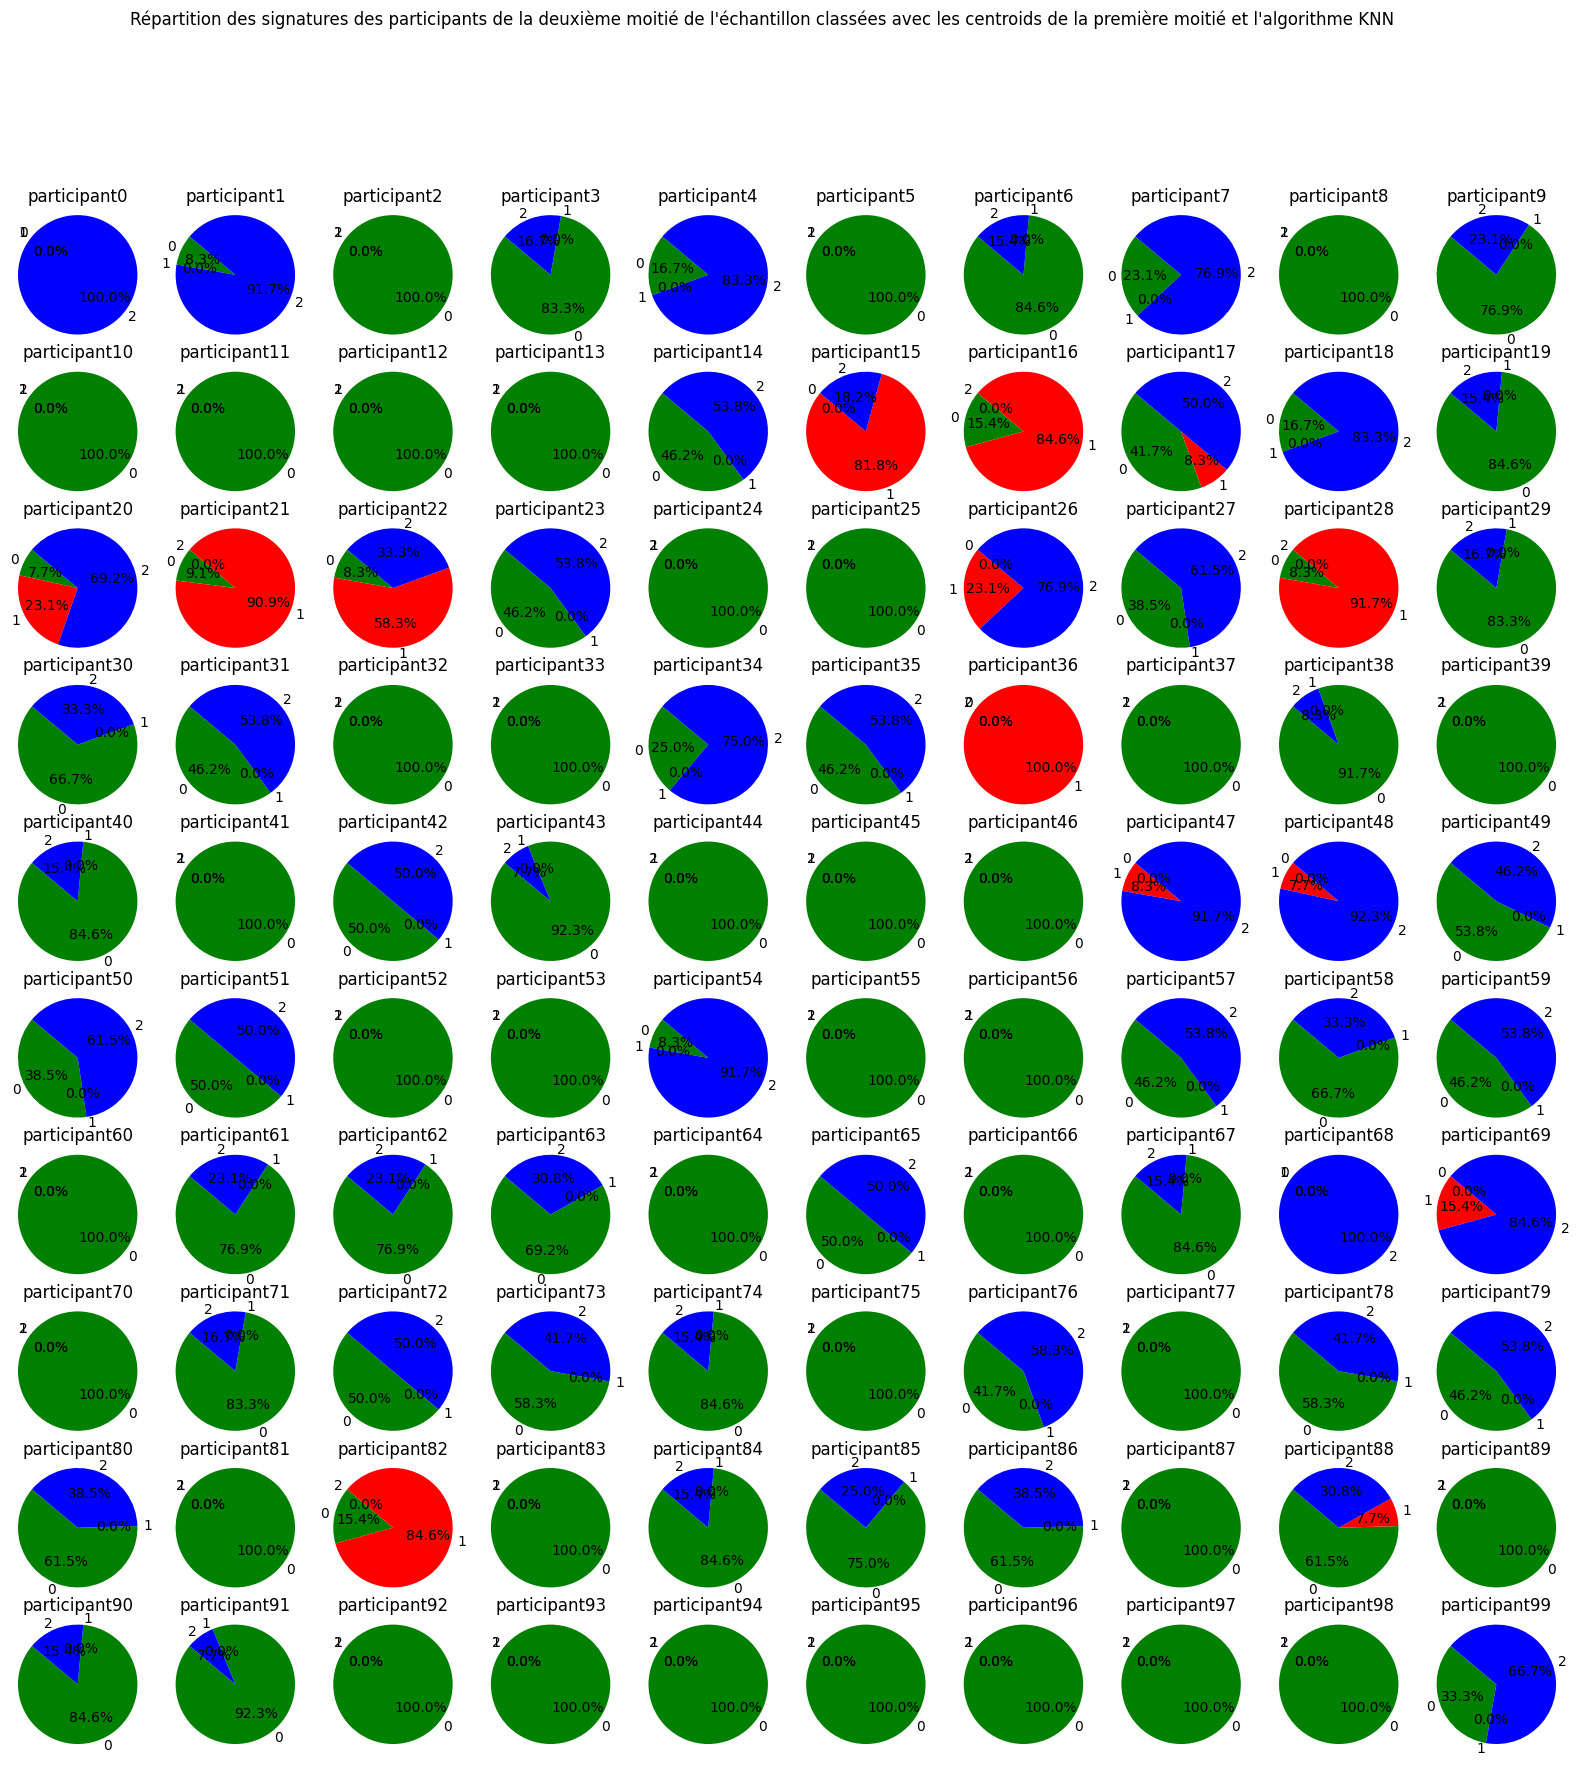

In [34]:
# plot the pie charts for the second half of the data, clustered using the centroids of the first half and the k-nearest neighbors algorithm
labels = ['0', '1', '2']
colors = ['green', 'red', 'blue']

fig, ax = plt.subplots(10,10, figsize= (20,20))
for i in range(10):
    for j in range(10):
        second_sample_participant = second_sample[second_sample["participant"] == i*10+j]
        sizes = np.bincount(second_sample_participant["cluster"])
        for k in range(3-sizes.shape[0]): # actually, reformat the 0% bit, because not readable
                sizes = np.append(sizes, 0)
        ax[i,j].pie(sizes, labels=labels, colors=colors,
                autopct='%1.1f%%', startangle=140)
        ax[i,j].axis('equal')
        ax[i,j].set_title("participant" + str(i*10+j))

plt.suptitle("Répartition des signatures des participants de la deuxième moitié de l'échantillon classées avec les centroids de la première moitié et l'algorithme KNN")
plt.show()  

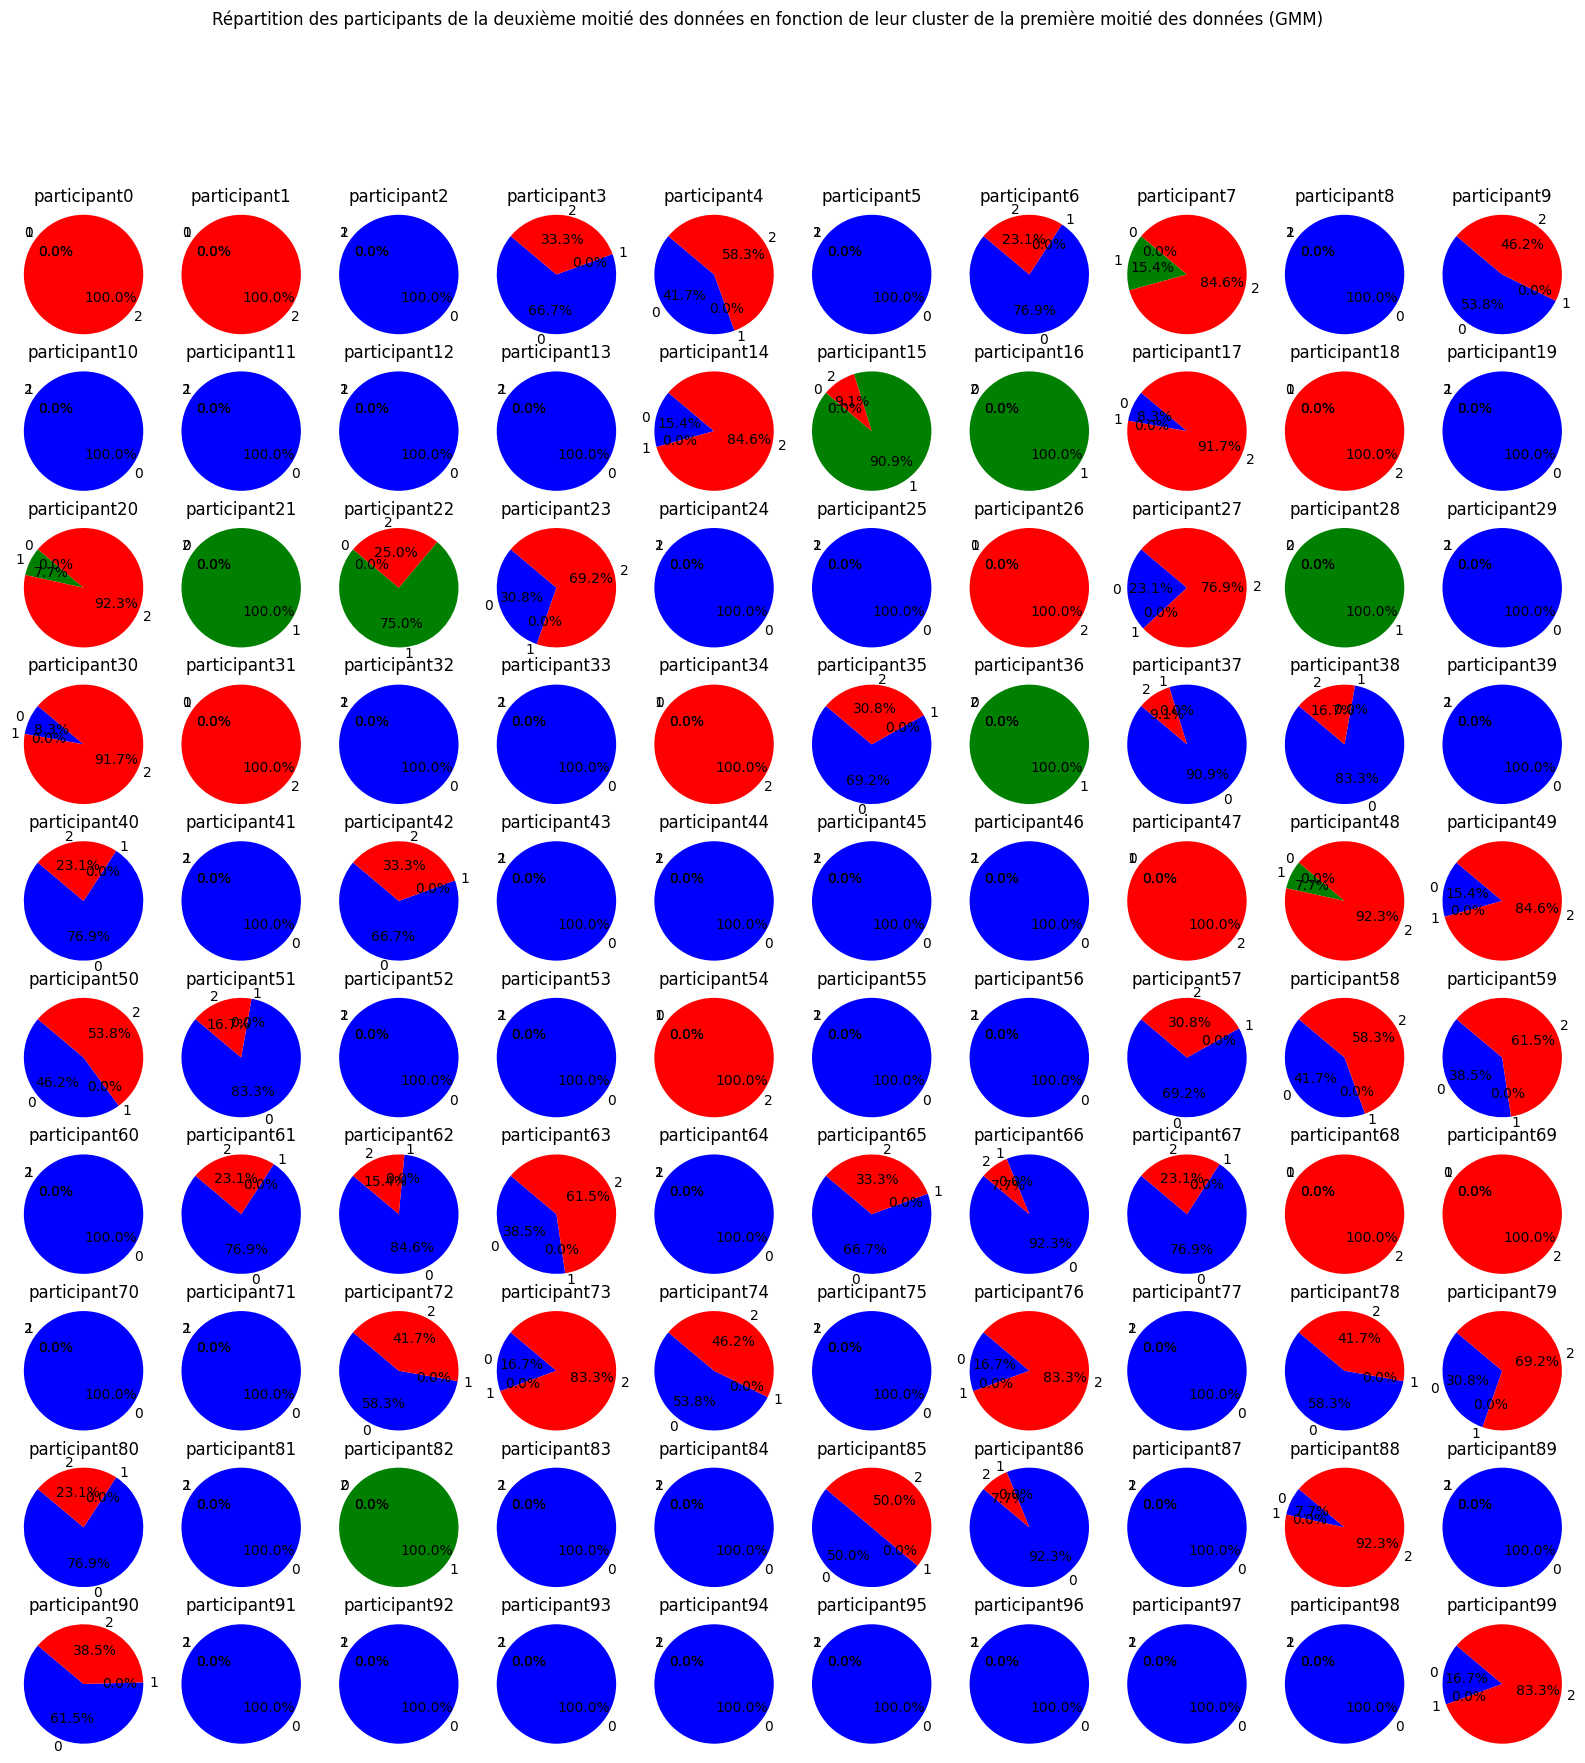

In [35]:
# plot the pie charts for the second half of the data, clustered previously with GMM
labels = ['0', '1', '2']
colors = ['blue', 'green', 'red']

fig, ax = plt.subplots(10,10, figsize= (20,20))
for i in range(10):
    for j in range(10):
        previous_clusters_participant = second_sample[second_sample["participant"] == i*10+j]
        sizes = np.bincount(previous_clusters_participant["previous_clusters"])
        for k in range(3-sizes.shape[0]): # actually, reformat the 0% bit, because not readable
                sizes = np.append(sizes, 0)
        ax[i,j].pie(sizes, labels=labels, colors=colors,
                autopct='%1.1f%%', startangle=140)
        ax[i,j].axis('equal')
        ax[i,j].set_title("participant" + str(i*10+j))
plt.suptitle("Répartition des participants de la deuxième moitié des données en fonction de leur cluster de la première moitié des données (GMM)")
plt.show()  

Finalement, cette deuxième approche est efficace avec une grande base de données : l’algorithme KNN est en effet très rapide et permet donc d’améliorer l’efficacité d’une classification. Cependant, en utilisant moins de données pour la première classification, on risque d’avoir des cas limites moins bien classifiés voire même mal classifiés à cause de l’aléatoire. Cette procédure pourrait également être utile pour classer des données arrivant en temps réel : à partir d’un certain volume de données, en s’assurant qu’il soit suffisamment hétérogène on pourrait effectuer la première classification puis appliquer KNN aux données arrivant en temps réel pour les classer rapidement. Il faudra cependant veiller à recalculer les représentants de chaque classe régulièrement pour éviter les fausses classifications.
